# Which tree species should the city plant?

## 📖 Background
You work for a nonprofit organization advising the planning department on ways to improve the quantity and quality of trees in New York City. The urban design team believes tree size (using trunk diameter as a proxy for size) and health are the most desirable characteristics of city trees.

The city would like to learn more about which tree species are the best choice to plant on the streets of Manhattan.

## 💪 Challenge
Create a report that covers the following:
* What are the most common tree species in Manhattan?
* Which are the neighborhoods with the most trees?
* A visualization of Manhattan's neighborhoods and tree locations.
* What ten tree species would you recommend the city plant in the future?

## Key insights : 
🗝 The three most common tree species in Manhattan are  Honeylocust , Caleri pear and Ginkgo species , with , respectively , 13176 , 7297 and 5859 trees.</br>
</br>
🗝 The neighborhoods with the most trees are Upper West Side , Upper East Side-Carnegie Hill and West Village , with , respectively , 5807 , 4616 and 3801 trees.</br>
</br>
🗝 The neighborhoods with the fewest trees, relative to their area, are Stuyvesant Town-Cooper Village, Midtown-Midtown South and Manhattanville. Maybe these are the places where the organization should focus its efforts.</br>
</br>
🗝 Most of the problems encountered by trees concern the roots, and the main cause of these are stones.</br>
</br>
🗝 Healthy trees tend to have larger trunks than unhealthy ones.

In [37]:
# Data manipulation
import pandas as pd 
import numpy as np
import geopandas as gpd 
from shapely.geometry import Point 

# Data visualisation
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 
import seaborn as sns

# Drop the warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:
trees = pd.read_csv('data/trees.csv')
trees.head(2)

,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude
0,190422,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770046,-73.984950
1,190426,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770210,-73.985338


In [39]:
neighborhoods = gpd.read_file('data/nta.shp')
neighborhoods.head(2)

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."


In [40]:
# Make a deep copy of the neighborhoods before modifying
neighborhoods_cop = neighborhoods.copy(deep=True)

# Subset to Manathan
neighborhoods = neighborhoods[neighborhoods['ntaname'].isin(list(trees['nta_name']))]

# Create the shapely points from the three dataframe
trees['points'] = trees.apply(lambda x : Point(float(x.longitude) , float(x.latitude)) , axis=1)

# Turn the tree dataframe to a Geopandas object
geo_trees = gpd.GeoDataFrame(trees , geometry=trees.points , crs=neighborhoods.crs)

# Create a geopandas dataframe with both the datasets
df = gpd.GeoDataFrame(geo_trees , geometry=neighborhoods.geometry , crs=neighborhoods.crs)

## Chart of the most common tree species and the "greenest" neighborhoods in Manhattan

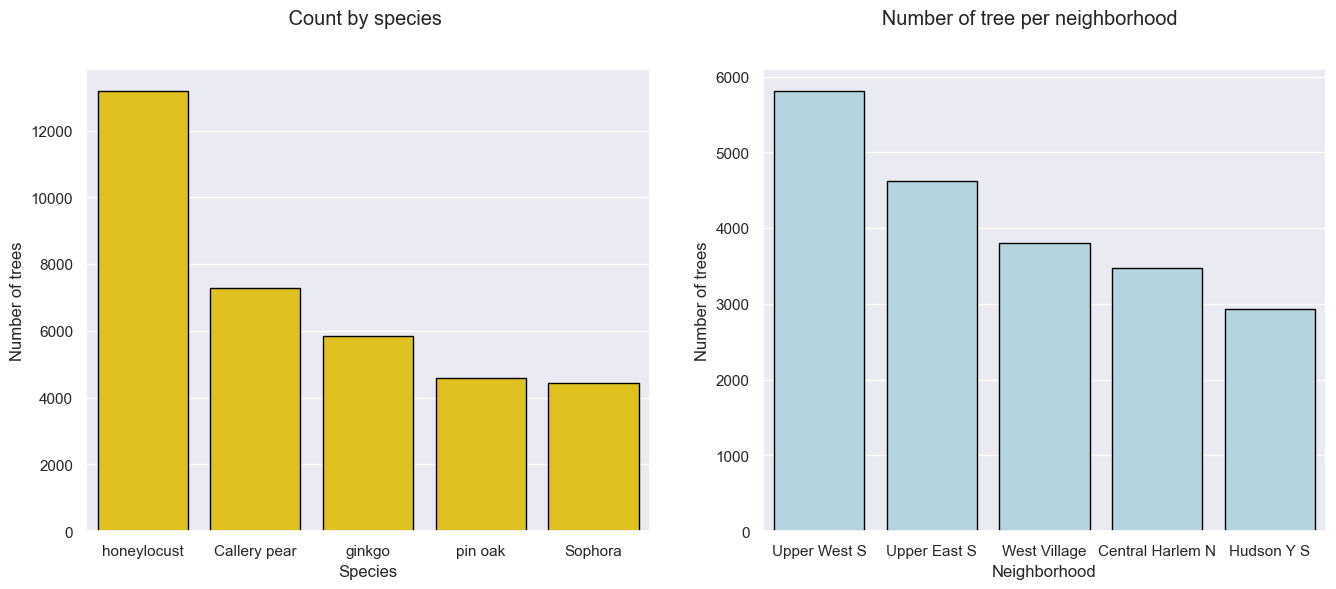

In [41]:
# Group the data by neiborhood
grouped_df = df.groupby('nta_name')[['tree_id']].count()

# Create a dict with the neiborhoods and the count of trees
dict_chloro = dict(grouped_df["tree_id"])

# Map the count
df['global_density'] = [dict_chloro.get(n) for n in df['nta_name']]

to_plot_sp = df.groupby('spc_common' , as_index=False)['tree_id'].count().nlargest(5 ,'tree_id')
to_plot_nb = df.groupby('nta_name' , as_index=False)['global_density'].mean().nlargest(5 , 'global_density')

# Neighborhood should be suitable for visualisation
new_names = []
for vals in list(to_plot_nb['nta_name']):
    first_piece = vals.split(' ')[0]
    if len(vals.split(' ')[1]) < 10:
        second_piece = vals.split(' ')[1]
    else:
        second_piece = vals.split(' ')[1][0]
    try:
        third_piece = vals.split(' ')[2][0]
    except:
        third_piece = ''
    new_names.append(f'{first_piece} {second_piece} {third_piece}'.rstrip())
to_plot_nb['nta_name'] = new_names


with sns.plotting_context('notebook'):
    sns.set_style('darkgrid')
    fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(16 ,6))
    sns.barplot(data=to_plot_sp , x='spc_common' , y='tree_id' , edgecolor='black' , color='gold' , ax=ax1)
    ax1.set_ylabel('Number of trees')
    ax1.set_xlabel('Species')
    sns.barplot(data=to_plot_nb , x='nta_name' , y='global_density' , edgecolor='black' , color='lightblue' , ax=ax2)
    ax2.set_ylabel('Number of trees')
    ax2.set_xlabel('Neighborhood')
    fig.suptitle('                 Count by species                                                                                Number of tree per neighborhood')



## Does trunk diameter have an impact on health ?
It seems so. Indeed, on this figure we can see that the median diameter of trees in poor health is clearly lower than the median diameter of trees in 'fair' health, itself lower than the median diameter of trees in good health.

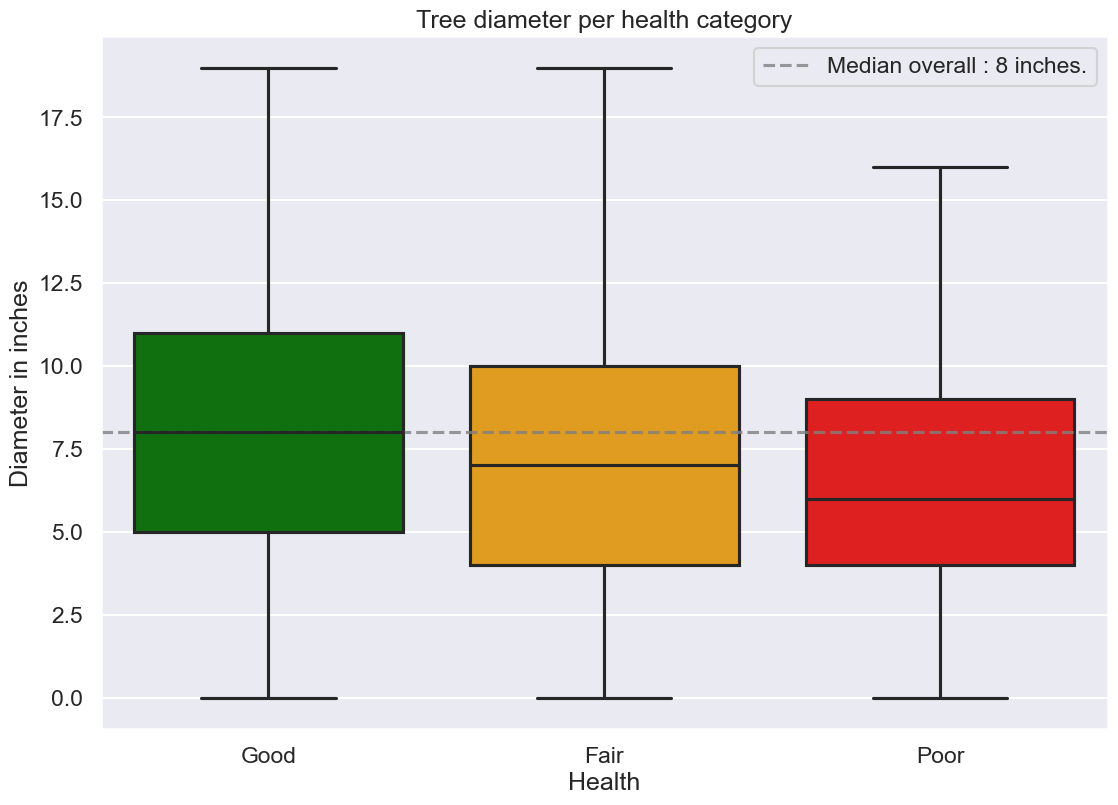

In [42]:
# Drop nan's in health column
trees.dropna(inplace=True , subset='health')

def remove_outliers(df=trees , column='tree_dbh'):
    '''Remove outliers from a specified column in a dataframe'''
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 
    low = Q1 - 1.5 * IQR 
    high = Q3 + 1.5 * IQR
    df = df[(df[column] > low) & (df[column] < high)]
    return df 

# Trees without outliers in the health column
trees_wo = remove_outliers()

# Colors for the boxplot
palette = {'Good' : 'green' , 'Fair' : 'orange' , 'Poor' : 'red'}

# Median or the diameter column
median_dbh = trees['tree_dbh'].median()

with sns.plotting_context('talk'):
    sns.set_style('darkgrid')
    plt.figure(figsize=(13 , 9))
    sns.boxplot(data=trees_wo , x='health' , y='tree_dbh' , showfliers = False , palette=palette)
    plt.axhline(median_dbh , color='grey' , alpha=0.8 , linestyle='--' , label=f'Median overall : {int(median_dbh)} inches.')
    plt.legend(loc='upper right')
    plt.ylabel('Diameter in inches')
    plt.xlabel('Health')
    plt.title('Tree diameter per health category')
    plt.show()

## What's upsetting our trees?
In this figure we can see the distribution of problems by cause and affected part of the trees, and this distribution shows us a clear trend. Indeed, more than 50 per cent of the problems encountered concern roots, compared to 20 and 30 per cent for branches and trunks. In them alone, stones are responsible for 32 percent of the total problems in our data set.

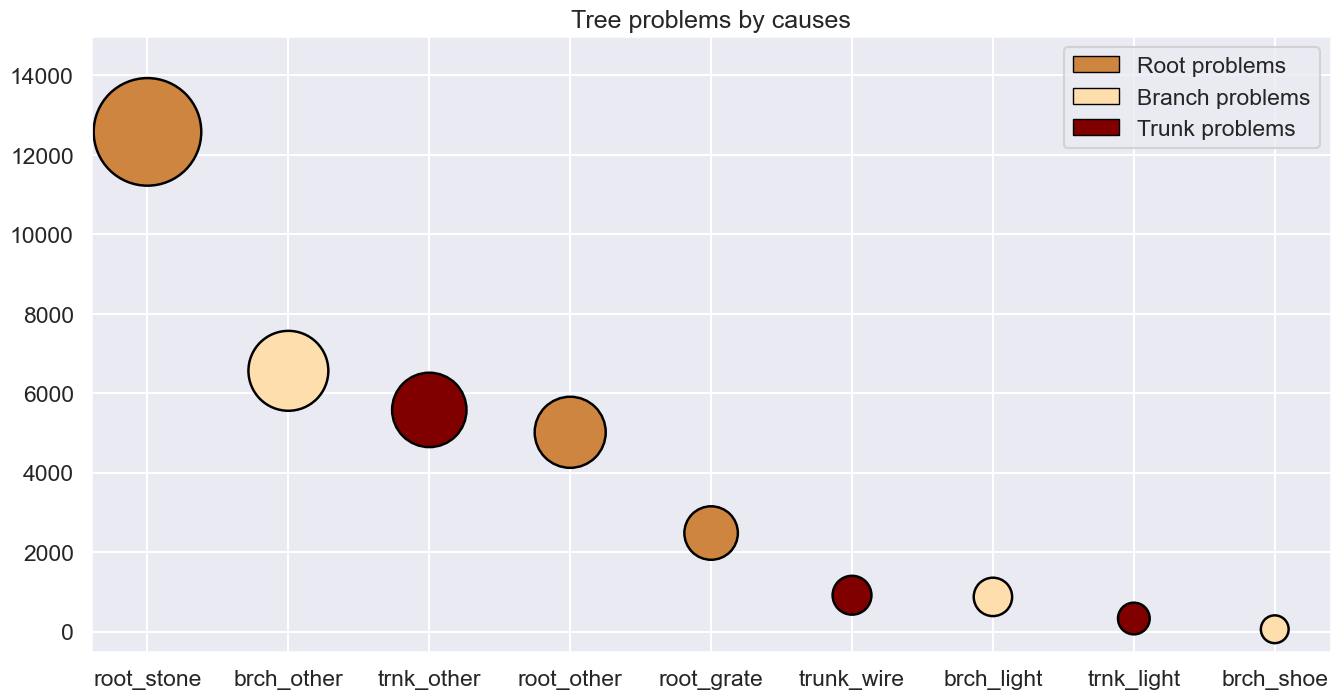

In [43]:
def clean(columns , df=trees):
    ''' Iterate throught the binary column to get replace string value per 1 or 0 '''
    for col in columns:
        df[col] = df[col].apply(lambda x : str(x).replace('No' , '0').replace('Yes' , '1').replace('Alive' , '0').replace('Dead' , '1')).astype(int)
    return df

# Change the categorical column to numerical for calculation
trees = clean(columns=["root_stone", "root_grate" , "root_other" , "trunk_wire"  , "trnk_light"  , "trnk_other"  , "brch_light" , "brch_shoe" ,"brch_other" , 'status'])


# Most common problem
sum_problems = dict(trees[['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light',
       'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']].sum(axis='rows').sort_values(ascending=False))
x_axis = [i for i in range(9)]
palette = ['peru' , 'navajowhite' , 'maroon' , 'peru' ,'peru' , 'maroon' ,'navajowhite' ,'maroon' , 'navajowhite']

line1 = Patch(facecolor='peru' , edgecolor='black')
line2 = Patch(facecolor='navajowhite' , edgecolor='black')
line3 = Patch(facecolor='maroon' , edgecolor='black')

root = sum_problems['root_stone'] + sum_problems['root_other'] + sum_problems['root_grate']
brch = sum_problems['brch_other'] + sum_problems['brch_light'] + sum_problems['brch_shoe']
trk = sum_problems['trnk_other'] + sum_problems['trnk_other'] + sum_problems['trnk_light']



with sns.plotting_context('talk'):
       sns.set_style('darkgrid')
       plt.figure(figsize=(16,8))
       sns.scatterplot(x=sum_problems.keys() , y=sum_problems.values()  ,size=sum_problems.values(), legend=False,  sizes=(400 , 6000) , edgecolor='black' , c=palette)
       plt.legend((line1, line2, line3), ('Root problems', 'Branch problems', 'Trunk problems'), numpoints=1, loc=1) 
       plt.title('Tree problems by causes')
       plt.ylim([-500 , 15000])
       plt.show()

## Where do the problems come from?
On this map we can see the density of tree problems by neighborhood (relative to the number of trees). We can clearly see that in eastern Manhattan the trees have more problems than elsewhere. This may be due to weak dominant species, or, more likely, neighborhoods that are not conducive to plant life. We can deepen this hypothesis by highlighting this map with the following one, on the tree density by district.</br>
The areas with the most problems are marked with a triangle.

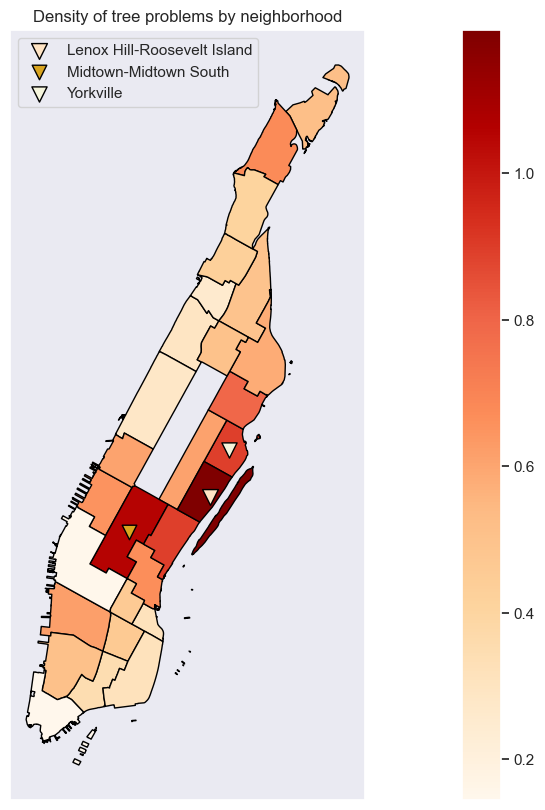

In [45]:
pbs = trees.groupby('nta_name' , as_index=False)[["root_stone", "root_grate" , "root_other" , "trunk_wire"  , "trnk_light"  , "trnk_other"  , "brch_light" , "brch_shoe" ,"brch_other"]].sum()
pbs['total'] = pbs[['root_stone',	'root_grate',	'root_other',	'trunk_wire',	'trnk_light',	'trnk_other',	'brch_light',	'brch_shoe',	'brch_other']].sum(axis=1)
dict_pbs = dict(zip(list(pbs['nta_name']) , list(pbs['total'])))


# Group the data by neiborhood
neighborhoods['global_density'] = [dict_chloro.get(n) for n in neighborhoods['ntaname']]
neighborhoods['total_pb'] = [dict_pbs.get(n) for n in neighborhoods['ntaname']]
neighborhoods['total_pb'] = neighborhoods['total_pb'] / neighborhoods['global_density']

# Centroids
lenox = neighborhoods[neighborhoods['ntaname'] == 'Lenox Hill-Roosevelt Island'].centroid
midtown = neighborhoods[neighborhoods['ntaname'] == 'Midtown-Midtown South'].centroid
yorkville = neighborhoods[neighborhoods['ntaname'] == 'Yorkville'].centroid

with sns.plotting_context('notebook'):
    sns.set_style('darkgrid')
    ax = neighborhoods.plot(column='total_pb' , cmap='OrRd' , edgecolor='black' , legend=True , figsize=(25,10))
    lenox.plot(marker='v' , ax=ax , edgecolor='black' , markersize=130 , c='bisque' , label='Lenox Hill-Roosevelt Island')
    midtown.plot(marker='v' , ax=ax , edgecolor='black' , markersize=110 , c='goldenrod' , label='Midtown-Midtown South')
    yorkville.plot(marker='v' , ax=ax , edgecolor='black' , markersize=120 , c='beige' , label='Yorkville')
    plt.yticks([])
    plt.xticks([])
    plt.title('Density of tree problems by neighborhood')
    plt.legend(loc='upper left')

## Density map of trees in Manhattan

As we can see on this map, the distribution of trees is far from homogeneous.</br>
We can also see that the three "problem areas" mentioned above are rather sparsely forested, relative to their sizes.</br>
The three most densely populated neighborhoods with trees are marked with a clover.


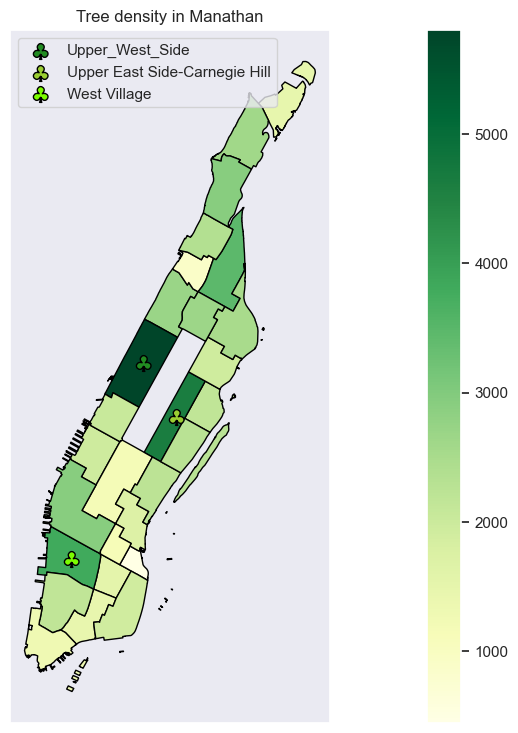

In [46]:
# Group the data by neiborhood
neighborhoods['global_density'] = [dict_chloro.get(n) for n in neighborhoods['ntaname']]

# Subset the centroids
Upper_West_Side = neighborhoods[neighborhoods['ntaname'] == 'Upper West Side'].centroid
Upper_East_Side_CH = neighborhoods[neighborhoods['ntaname'] == 'Upper East Side-Carnegie Hill'].centroid
West_Village = neighborhoods[neighborhoods['ntaname'] == 'West Village'].centroid

with sns.plotting_context('notebook'):
    sns.set_style('darkgrid')
    ax = neighborhoods.plot(column='global_density' , cmap='YlGn' , edgecolor='black' , legend=True , figsize=(25,9))
    plt.yticks([])
    plt.xticks([])
    plt.title('Tree density in Manathan')
    Upper_West_Side.plot(marker=r'$\clubsuit$' , ax=ax , edgecolor='black' , markersize=150 , c='forestgreen' , label='Upper_West_Side')
    Upper_East_Side_CH.plot(marker=r'$\clubsuit$' , ax=ax , edgecolor='black' , markersize=150 , c='yellowgreen' , label='Upper East Side-Carnegie Hill')
    West_Village.plot(marker=r'$\clubsuit$' , ax=ax , edgecolor='black' , markersize=150 , c='lawngreen' , label='West Village')
    plt.legend(loc='upper left')
    plt.show()

## Are the problems related to health?
Naturally. There is a very strong negative correlation between the percentages of problems encountered by trees and the percentages of trees in good health. For the longevity of trees, perhaps it would be interesting to focus not only on the planting, but also on the environment in which these trees evolve , by making, for example, the areas most hostile to plant life more livable.</br>
Areas with the highest percentages of healthy trees are marked with a cross.

Correlation between the percentages of problems and the percentages of trees in good health :  -0.71
--------------------------------------------------------


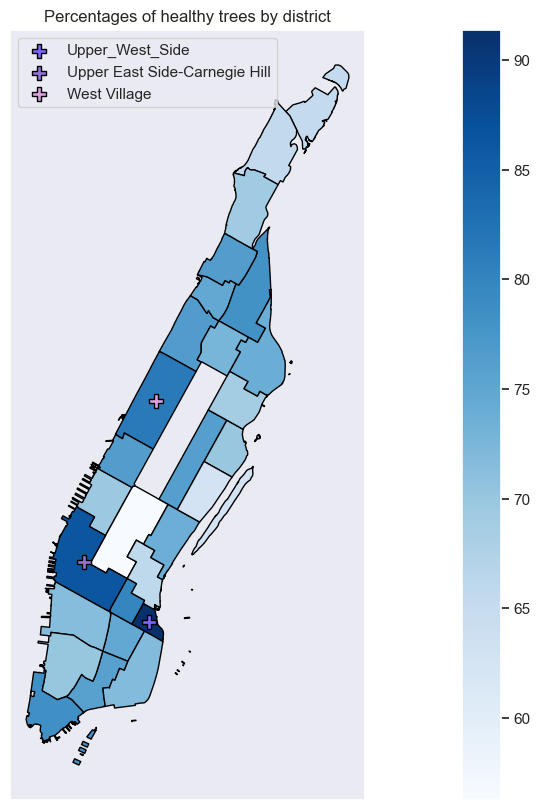

In [47]:
b = trees.groupby('nta_name' , as_index=False)['health'].value_counts()
b['total_count'] = [dict_chloro.get(n) for n in list(b['nta_name'])] 
b['percentage'] = b['count'] / b['total_count'] * 100
b = b[b['health'] == 'Good']
dict_perc = dict(zip(list(b['nta_name']) , list(b['percentage'])))
neighborhoods['percentage'] = [dict_perc.get(n) for n in list(neighborhoods['ntaname'])]

stu = neighborhoods[neighborhoods['ntaname'] == 'Stuyvesant Town-Cooper Village'].centroid 
hic = neighborhoods[neighborhoods['ntaname'] == 'Hudson Yards-Chelsea-Flatiron-Union Square'].centroid
uws = neighborhoods[neighborhoods['ntaname'] == 'Upper West Side'].centroid


with sns.plotting_context('notebook'):
    sns.set_style('darkgrid')
    ax = neighborhoods.plot(column='percentage' , cmap='Blues' , edgecolor='black' , legend=True , figsize=(25,10))
    stu.plot(marker='P' , ax=ax , edgecolor='black' , markersize=110 , c='mediumslateblue' , label='Upper_West_Side')
    hic.plot(marker='P' , ax=ax , edgecolor='black' , markersize=100 , c='mediumpurple' , label='Upper East Side-Carnegie Hill')
    uws.plot(marker='P' , ax=ax , edgecolor='black' , markersize=95 , c='plum' , label='West Village')
    plt.yticks([])
    plt.xticks([])
    plt.legend(loc='upper left')
    plt.title('Percentages of healthy trees by district')
    
print('Correlation between the percentages of problems and the percentages of trees in good health : ' , round(neighborhoods['total_pb'].corr(neighborhoods['percentage']),3))
print('--------------------------------------------------------')

## The ten best species

In order to determine the ten most desirable species, I used a custom KPI (Key Performance Indicator). Indeed, I took into account the percentage of healthy trees for each species, as well as the average trunk diameter (the larger the better). I also gave a rating of robustness, depending on whether the external elements, such as the presence of paving stones around the tree, tends to cause him problems or not. 
All this combined gave me an overall score, out of 100, which I used to rank the species.</br>
The formula is as follows: (Percentage of healthy tree within the species + percentage of species whose mean trunk diameter is smaller than this one) / 2 - Penalty of problem caused by external elements.

In [49]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return y * 100



def clean(columns , df=trees):
    ''' Iterate throught the binary column to get replace string value per 1 or 0 '''
    for col in columns:
        df[col] = df[col].apply(lambda x : str(x).replace('No' , '0').replace('Yes' , '1').replace('Alive' , '0').replace('Dead' , '1')).astype(int)
    return df

# Change the categorical column to numerical for calculation
trees = clean(columns=["root_stone", "root_grate" , "root_other" , "trunk_wire"  , "trnk_light"  , "trnk_other"  , "brch_light" , "brch_shoe" ,"brch_other" , 'status'])



# Group data by species , get the mean trunk diameter 
grp_species = trees.groupby('spc_common' , as_index=False)[['tree_id' , 'tree_dbh']].agg({'tree_id' : 'count' , 'tree_dbh' : 'mean'}).sort_values(by='tree_dbh')
grp_species = grp_species[grp_species['spc_common'] != 'tree of heaven'] # Invasive and dangerous species
grp_species = grp_species[grp_species['tree_id'] >= 30]
grp_species['perc_dbh'] = ecdf(grp_species['tree_dbh'].values)


# Group the data by species AND health
grp = trees.groupby(['spc_common' , 'health'] , as_index=False)[['tree_id' , 'health']].agg({'tree_id' : 'count'})

# Create dict to map the data for the count and diameters
dict_count = dict(grp.groupby('spc_common')['tree_id'].sum())
dict_dbh = dict(zip(list(grp_species['spc_common']) , list(grp_species['tree_dbh'].apply(lambda x : round(x , 2)))))
dict_perc_dbh = dict(zip(list(grp_species['spc_common']) , list(grp_species['perc_dbh'].apply(lambda x : round(x , 2)))))


# Create a total count column
grp['total_count'] = [dict_count.get(spec) for spec in list(grp['spc_common'])]

# Percentage of tree in each species and each healh categories
grp['percentage'] = round((grp['tree_id'] / grp['total_count']) * 100 , 2)

# Add the diameters and pourcentage of values before each point
grp['tree_dbh'] = [dict_dbh.get(spec) for spec in list(grp['spc_common'])]
grp['perc_dbh'] = [dict_perc_dbh.get(spec) for spec in list(grp['spc_common'])]

# Create a dataframe grouped by species , with the problems each species has
grp_pb = trees.groupby('spc_common' , as_index=False)[["root_stone", "root_grate" , "root_other" , "trunk_wire"  , "trnk_light"  , "trnk_other"  , "brch_light" , "brch_shoe" ,"brch_other" , 'status']].sum()

# Get the total count for the 'problem' dataframe
grp_pb['total_count'] = [dict_count.get(spec) for spec in grp_pb['spc_common']]

# Create a penalty column with this formula : (sum(problems) / total_count) * 10
grp_pb['penalty'] = (grp_pb.drop(['spc_common' , 'total_count'] , axis=1).sum(axis=1).values / grp_pb['total_count'].values) * 10

# Subset the dataframes to get only the species with good health and enought information
grp = grp[(grp['spc_common'].isin(list(grp_species['spc_common']))) & (grp['health'] == 'Good')]
grp_pb = grp_pb[grp_pb['spc_common'].isin(list(grp['spc_common']))]

# Add the penalty column in the grp dataframe
grp['penalty'] = grp_pb['penalty'].values
grp = grp.reset_index(drop=True)

# Add a score column with the following KPI : ((percentage_of_tree_in_good_health + percentile of the point) / 2) - penalty
grp['score'] = ((grp['percentage'] + grp['perc_dbh']) / 2) - grp['penalty']

# Subset with only the columns of interest
grp = grp[['spc_common' , 'total_count' , 'percentage' , 'tree_dbh' , 'penalty' , 'score']]

# Get the top 10 species 
top_species = grp.nlargest(n=10 , columns=['score']).reset_index(drop=True)
top_species['penalty'] = 10 - top_species['penalty'] 
based_columns = top_species.columns
top_species.columns = ['Species' , 'Count in Manhattan' , '% in good health' , 'Mean tree diameter' , 'Robustness' , 'Overall score']
top_species.index = [i for i in range(1 , 11)]

# Display the results
print('The ten best species and their attributes (maximum in green , minimum in red) :\n -----------------------------------------------------------------------------------')
top_species.style.highlight_max(subset=['Count in Manhattan' , '% in good health' , 'Mean tree diameter' , 'Robustness' , 'Overall score'] , color='lawngreen').highlight_min(subset=['Count in Manhattan' , '% in good health' , 'Mean tree diameter' , 'Robustness' , 'Overall score'] , color='red')

The ten best species and their attributes (maximum in green , minimum in red) :
 -----------------------------------------------------------------------------------


,Species,Count in Manhattan,% in good health,Mean tree diameter,Robustness,Overall score
1,Siberian elm,156,83.970000,12.060000,5.833333,86.233333
2,American elm,1698,80.150000,13.900000,5.712603,85.787603
3,willow oak,889,84.030000,10.810000,4.071991,82.911991
4,pin oak,4584,81.390000,10.070000,5.257417,81.192417
5,white ash,50,80.000000,9.800000,6.400000,80.845000
6,mulberry,68,70.590000,11.000000,5.441176,78.356176
7,black locust,259,77.610000,9.770000,4.594595,77.049595
8,black walnut,33,78.790000,9.640000,4.242424,76.492424
9,London planetree,4122,63.000000,13.170000,5.167394,75.872394
10,Sophora,4453,79.810000,9.230000,4.271278,74.651278


## Visualization of their attributes
On these visualizations we can see the strengths and weaknesses of the ten highest scoring species.

The ten best species, in descending order of score :
----------------------------------------------------------------------------------


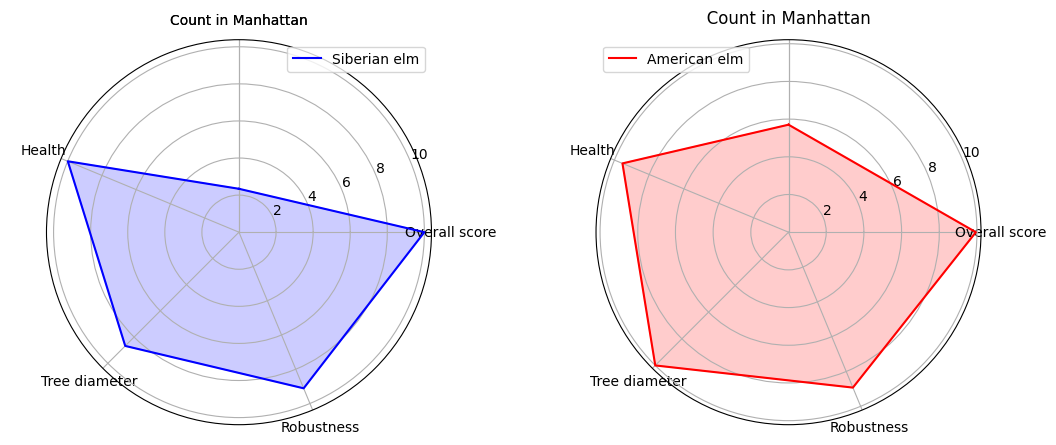

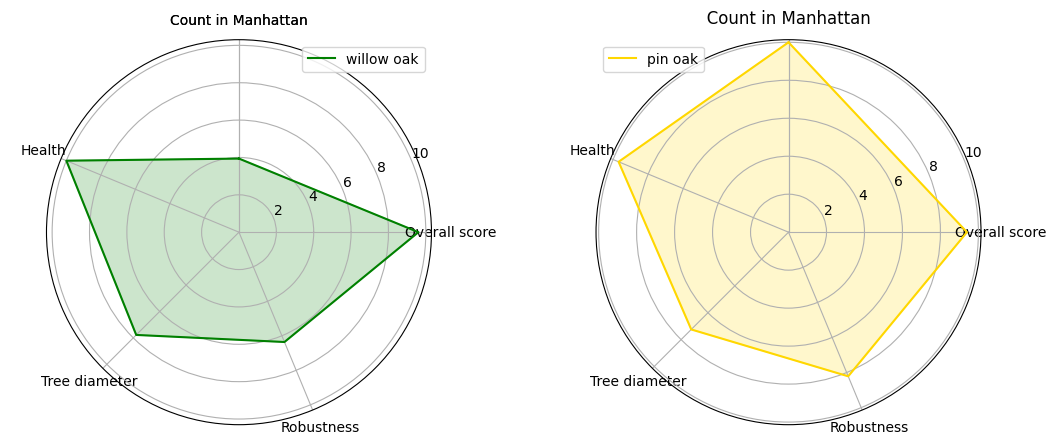

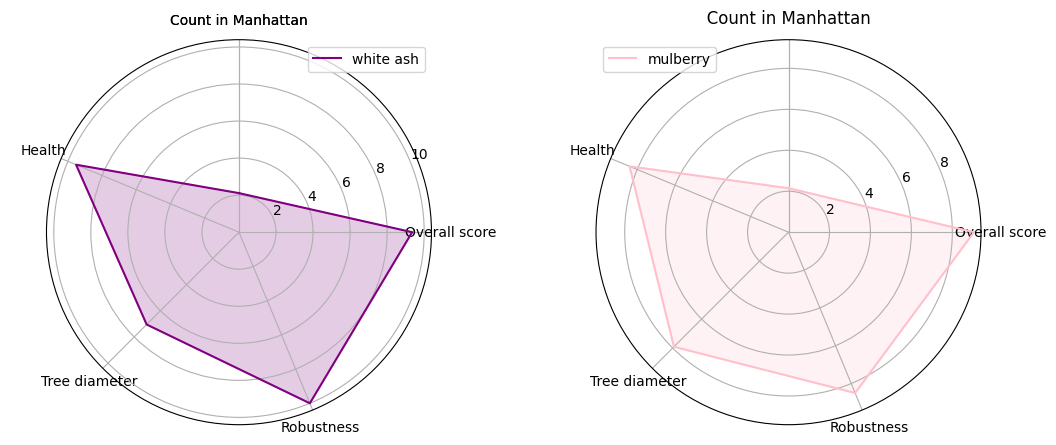

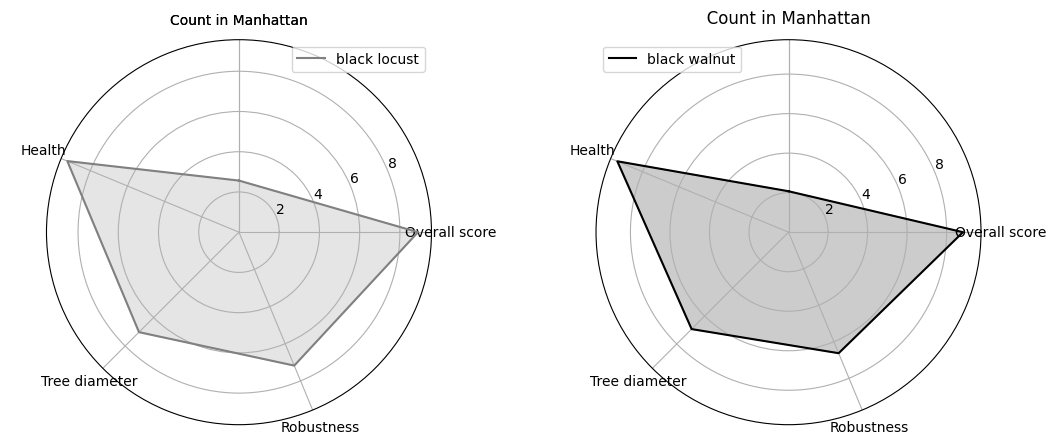

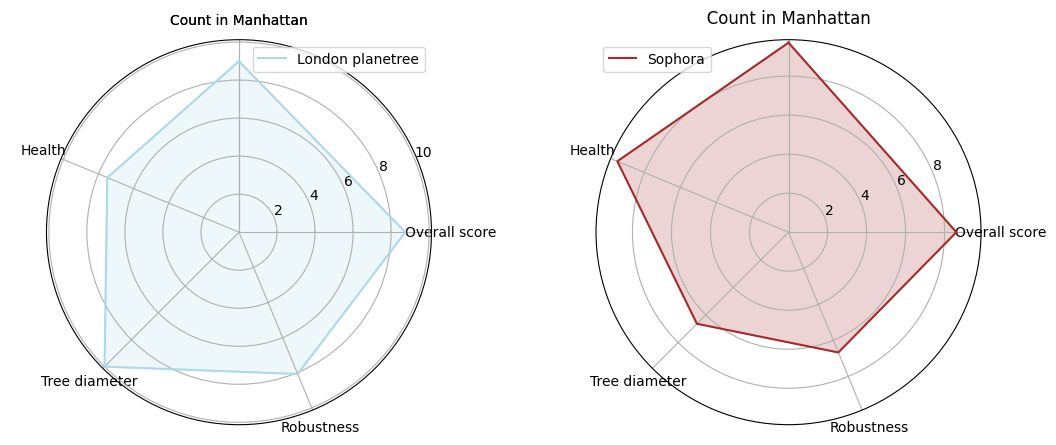

In [50]:
# Create a copy of the top 10 species dataframe
top_species.index = [i for i in range(10)]
top_species.columns = based_columns
top_to_plot = top_species.copy(deep=True)

# Scale the data on the range 0 - 10 , using the max value of the column
for col in top_to_plot.drop('spc_common' , axis=1):
    max_val = top_to_plot[col].max()
    top_to_plot[col] = (top_to_plot[col].values / max_val) * 10


# Regulize for visualisation
top_to_plot.loc[8 , 'tree_dbh'] = 10
top_to_plot = top_to_plot.sort_values(by='total_count' , ascending=False).reset_index(drop=True)
top_to_plot['total_count'] = [top_to_plot['total_count'][i] + 2 if top_to_plot['total_count'][i] < 8 else top_to_plot['total_count'][i]  for i in range(10)] # For visualisation
top_to_plot = top_to_plot.sort_values(by='score' , ascending=False).reset_index(drop=True)
top_to_plot['score'] = [top_to_plot['score'][i] - (i * 0.006) for i in range(10)]

plt.style.use('default')
species = list(top_to_plot['spc_common'])
colors = ['blue' , 'red' , 'green' , 'gold' , 'purple' , 'pink' , 'grey' , 'black' , 'lightblue' , 'brown']

print('The ten best species, in descending order of score :\n----------------------------------------------------------------------------------')
for i in range(0 , 10 , 2):
    
    # Plot the results two by two , as thetagrids
    label_pos = np.linspace(start=np.pi / 2, stop=2 * np.pi, num=5, endpoint=True)
    label_pos = np.concatenate((label_pos, [label_pos[0]]))
    labels0 = ['Count in Manhattan' , 'Health', 'Tree diameter' , 'Robustness', 'Overall score']
    labels0.append('Count in Manhattan')
    labels1 = ['Count in Manhattan' , 'Health', 'Tree diameter' , 'Robustness', 'Overall score']
    labels1.append('')

    val1 = np.squeeze(top_to_plot[top_to_plot['spc_common'] == species[i]][['total_count',	'percentage',	'tree_dbh',	'penalty',	'score']].values).tolist()
    val1.append(val1[0]) # So the figures are closed

    val2 =  np.squeeze(top_to_plot[top_to_plot['spc_common'] == species[i+1]][['total_count',	'percentage',	'tree_dbh',	'penalty',	'score']].values).tolist()
    val2.append(val2[0])


    fig, ax = plt.subplots(1,2, figsize=(13,5))
    gs = GridSpec(1, 2)
    ax[0].axis('off')
    ax[0]= fig.add_subplot(gs[0,0], projection='polar')
    ax[0].plot(label_pos, val1, label=species[i], color=colors[i])
    ax[0].fill(label_pos, val1, color=colors[i], alpha = 0.2)
    lines, labels = plt.thetagrids(np.degrees(label_pos), labels=labels0)
    plt.legend(loc='upper right')

    ax[1].axis('off')
    ax[1]= fig.add_subplot(gs[0,1], projection='polar')
    ax[1].plot(label_pos, val2, label=species[i+1], color=colors[i+1])
    ax[1].fill(label_pos, val2, color=colors[i+1], alpha = 0.2)
    lines, labels = plt.thetagrids(np.degrees(label_pos), labels=labels1)
    plt.legend(loc='upper left')
    fig.suptitle('                                                                                                               Count in Manhattan' , y=0.94)

## Species recommendations

🌳 1 ) **_Siberian elm_** <br/>
<br/>
Strong point: its trunk diameter of more than 12 inches. The rest of its attributes, namely its overall health and robustness score, are quite correct. This species , native of Asia , is not very present in the streets of Manhattan , with only 156 trees listed. She gets the highest overall score.


🌳 2) **_American elm_** <br/>
<br/>
Strong point: The largest trunk diameter of this ranking (almost 14 inches). This species is considered to be very hardy. She’s in second place.


🌳 3) **_Willow oak_** <br/>
<br/>
Strong point: This species, native to the south-central and eastern United States, has the best overall health of this ranking and a good trunk diameter (almost 11 inches). However, she is quite prone to problems, with the worst robustness score in the standings. She comes third. 


🌳 4 ) **_Pin oak_** <br/>
<br/>
Strong point: This species is the most represented of this ranking, with 4584 trees. Its overall health, robustness and trunk diameter are good but not excellent , relative to this classification. Its trees are among the most commonly used landscaping oaks in its original range due to its ease of transplantation, relatively rapid growth and tolerance to pollution. She finishes fourth.


🌳 5 ) **_White ash_** <br/>
<br/>
Strong point: The White ash species has the highest robustness score in the ranking, which means it is the least prone to problems. 
She finished halfway through the ranking.


🌳 6 ) **_Mulberry_** <br/>
<br/>
Strong point: The diameter of its trunk is correct (11 inches), but its percentage of healthy individuals is the second lowest in the ranking. It is interesting to note that this species can produce delicious fruits. She finishes sixth.


🌳 7 ) **_Black locust_** <br/>
<br/>
The attributes of this species are average , relative to the top ranked species. Interesting fact ; this species is distinguished by its fragrant white flowers, which smell of citrus fruits.


🌳 8 ) **_Black wallnut_** <br/>
<br/>
The overall health, robustness score and average diameter of this species are very similar to Black locust. It can produce edible fruits; nuts. It is the least represented species in Manhattan, with only 33 individuals.

🌳 9 ) **_London planetree_** <br/>
<br/>
Strong point : The diameter of its trunk is the second largest of this classification (13 inches). Unfortunately, it also has the lowest overall health score, with only 63% in good health of its 4122 individuals. Maybe this species needs special care. She finishes before last.

🌳 10 ) **_Sophora_** <br/>
<br/>
This species , native to Asia , gets a suitable general health score , and is highly represented in the streets of Manhattan , with almost 4500 individuals . However the diameter of its trunk of only 9 inches and its low robustness score propels her to the last place of this ranking. 

## The ten best species, by category

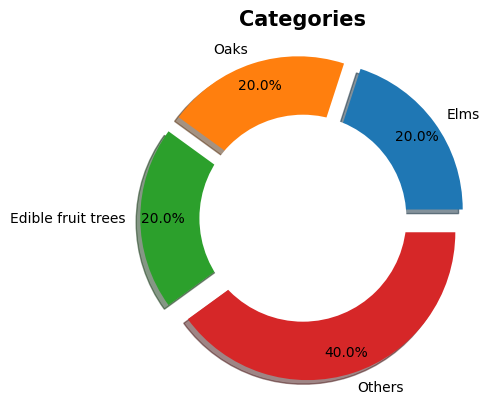

In [51]:
# Create variables for the pie viz
elm = oak = eatable = 2/10
other = 4/10

vals = [elm , oak , eatable , other]
labels = ['Elms' , 'Oaks' , 'Edible fruit trees' , 'Others']

explode = (0.1,0.1,0.1,0.1)
plt.pie(vals, labels=labels, autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=True)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Categories", fontsize=15, fontweight='bold')
plt.show()

## Final thoughts
In order to push the analysis further, it could be interesting to collect data on the causes of death or poor health of the different trees. It would also be beneficial to include ecological considerations in the choice of trees to be planted. Thanks for reading this far, and I wish you a Happy New Year !